In [27]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np
import os

json_file = '/content/Y-W-golden_repetition.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)

for key, value in data.items():
    print(key, value)


config {'iou_threshold': 0.5, 'limb_activity_threshold': 0.25, 'node_axis_threshold': 0.15, 'number_points_displayed': 5}
used_nodes [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_EYE', 'index': 1}, {'name': 'RIGHT_EYE', 'index': 2}, {'name': 'LEFT_EAR', 'index': 3}, {'name': 'RIGHT_EAR', 'index': 4}, {'name': 'LEFT_SHOULDER', 'index': 5}, {'name': 'RIGHT_SHOULDER', 'index': 6}, {'name': 'LEFT_ELBOW', 'index': 7}, {'name': 'RIGHT_ELBOW', 'index': 8}, {'name': 'LEFT_WRIST', 'index': 9}, {'name': 'RIGHT_WRIST', 'index': 10}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}, {'name': 'LEFT_KNEE', 'index': 13}, {'name': 'RIGHT_KNEE', 'index': 14}, {'name': 'LEFT_FOOT', 'index': 15}, {'name': 'RIGHT_FOOT', 'index': 16}]
affine_transform_nodes [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}]
evaluation_nodes [{'name': 'LEFT_WRIST', 'index': 9}, {'name': 'RIGHT_WRIST', 'index': 10}]
golden_rep_poses [{'timestamp': 0, 'po

In [28]:
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts

def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    for timestamp in data['golden_rep_poses']:
        positions = timestamp['pose']
        list_of_tuples_for_each_timestamp = [
            [positions[i], positions[i+1]] for i in range(0, 34, 2)
        ]
        list_of_positions.append(list_of_tuples_for_each_timestamp)
    return list_of_positions

def transform_list_of_positions(list_of_positions):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down

    When we will need to add a scale it's a good place to do so.

    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            # print(node)

    return list_of_positions

def center_skeleton(list_of_positions):
    """Centers the skeleton in the frame by shifting all coordinates."""
    for frame in list_of_positions:
        # Calculate the center of the skeleton
        x_coords = [node[0] for node in frame]
        y_coords = [node[1] for node in frame]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)

        # Shift all nodes to center the skeleton
        for node in frame:
            node[0] -= center_x - 0.5  # Centering on the x-axis (0.5 is the center)
            node[1] -= center_y - 0.5  # Centering on the y-axis (0.5 is the center)
    return list_of_positions

def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

def get_velocity(trace):
    x_vel = []
    y_vel = []
    for frame in trace:
        x_vel.append(frame[0])
        y_vel.append(frame[1])

    return np.gradient(np.array(x_vel)), np.gradient(np.array(y_vel))


HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]

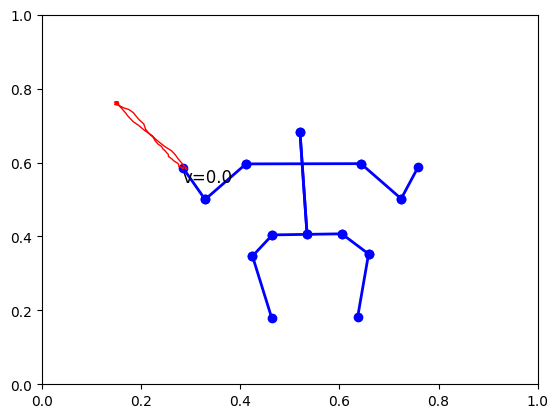

In [30]:
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')

# Add the connection from the MID_HIP to the NOSE
HUMAN_BLUEPRINT.append(('MID_HIP', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]

trace = get_trace('LEFT_WRIST', list_of_positions, body_parts)
x_vel, y_vel = get_velocity(trace)
# print(x_vel)
velocity = np.sqrt(x_vel**2 + y_vel**2)
# print(velocity)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
trace_line, = ax.plot([], [], 'r-', lw=1)
velocity_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=12, verticalalignment='top')



def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)


    if i < len(trace):
        trace_x = [pos[0] for pos in trace[:i+1]]
        trace_y = [pos[1] for pos in trace[:i+1]]
        trace_line.set_data(trace_x, trace_y)

    current_velocity = velocity[i]
    velocity_text.set_text(f'v={round(current_velocity, 3)}')
    velocity_text.set_position((trace_x[-1], trace_y[-1]))

    # print(velocity)
    return lines + [trace_line]

    # return lines

# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)
os.makedirs('Animations', exist_ok=True)
gif_path = os.path.join('Animations', os.path.basename(json_file).replace('.json', '_animation.gif'))
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()


In [31]:
# Calculate stability metrics for each node
stability_metrics = {}

for part, index in body_parts.items():
    x_positions = [frame[index][0] for frame in list_of_positions]
    y_positions = [frame[index][1] for frame in list_of_positions]

    # Mean position
    mean_x = np.mean(x_positions)
    mean_y = np.mean(y_positions)

    # Variance and standard deviation
    variance_x = np.var(x_positions)
    variance_y = np.var(y_positions)
    std_dev_x = np.std(x_positions)
    std_dev_y = np.std(y_positions)

    # Amplitude of motion
    amplitude_x = max(x_positions) - min(x_positions)
    amplitude_y = max(y_positions) - min(y_positions)

    # Direction vector (displacement)
    direction_vector = (x_positions[-1] - x_positions[0], y_positions[-1] - y_positions[0])

    stability_metrics[part] = {
        'mean_position': (mean_x, mean_y),
        'variance': (variance_x, variance_y),
        'std_dev': (std_dev_x, std_dev_y),
        'amplitude': (amplitude_x, amplitude_y),
        'direction_vector': direction_vector
    }

# Print the stability metrics
for part, metrics in stability_metrics.items():
    print(f"Node: {part}")
    print(f"  Mean Position: {metrics['mean_position']}")
    print(f"  Variance: {metrics['variance']}")
    print(f"  Standard Deviation: {metrics['std_dev']}")
    print(f"  Amplitude: {metrics['amplitude']}")
    print(f"  Direction Vector: {metrics['direction_vector']}")
    print()


Node: NOSE
  Mean Position: (0.5169097311728823, 0.6804058615085298)
  Variance: (2.5519594066550907e-05, 1.3332877503552459e-05)
  Standard Deviation: (0.005051692198318392, 0.0036514212991042897)
  Amplitude: (0.021209299564361572, 0.011814355850219727)
  Direction Vector: (0.00042134523391723633, -9.948015213012695e-05)

Node: LEFT_EYE
  Mean Position: (0.49012860286552296, 0.6937243410971312)
  Variance: (2.641287581083916e-05, 2.956769602287029e-06)
  Standard Deviation: (0.0051393458543708805, 0.0017195259818586716)
  Amplitude: (0.01975947618484497, 0.007664680480957031)
  Direction Vector: (0.0017955601215362549, 0.0003001689910888672)

Node: RIGHT_EYE
  Mean Position: (0.5406821037815736, 0.6944409637852053)
  Variance: (2.102979729392987e-05, 7.668106365302445e-06)
  Standard Deviation: (0.004585825693801485, 0.0027691345877913637)
  Amplitude: (0.018024563789367676, 0.008815646171569824)
  Direction Vector: (0.0014521479606628418, -0.00018015503883361816)

Node: LEFT_EAR
  M

config {'iou_threshold': 0.5, 'limb_activity_threshold': 0.25, 'node_axis_threshold': 0.15, 'number_points_displayed': 5}
affine_transform_nodes [{'name': 'NOSE'}, {'name': 'LEFT_HIP'}, {'name': 'RIGHT_HIP'}]
evaluation_nodes [{'name': 'LEFT_WRIST'}]
golden_rep_poses [{'timestamp': 0, 'pose': [0.5113, 0.2487, 0.4863, 0.2349, 0.5478, 0.2321, 0.4705, 0.2432, 0.5762, 0.24, 0.3959, 0.3551, 0.6801, 0.3564, 0.3421, 0.4749, 0.6974, 0.4882, 0.3024, 0.5923, 0.7421, 0.5978, 0.458, 0.5779, 0.6251, 0.5774, 0.4472, 0.6454, 0.6115, 0.6552, 0.456, 0.8549, 0.6131, 0.8591]}, {'timestamp': 30, 'pose': [0.5104, 0.2496, 0.4841, 0.2355, 0.5456, 0.2331, 0.4686, 0.2436, 0.5747, 0.2402, 0.3963, 0.3551, 0.681, 0.3561, 0.3416, 0.4765, 0.6979, 0.4883, 0.3055, 0.5876, 0.7431, 0.598, 0.4574, 0.5784, 0.6255, 0.5782, 0.4451, 0.6467, 0.6106, 0.6559, 0.456, 0.8569, 0.6129, 0.8601]}, {'timestamp': 70, 'pose': [0.5096, 0.25, 0.483, 0.2358, 0.5451, 0.233, 0.4683, 0.2443, 0.5745, 0.2403, 0.3975, 0.3538, 0.6807, 0.3559, 0.

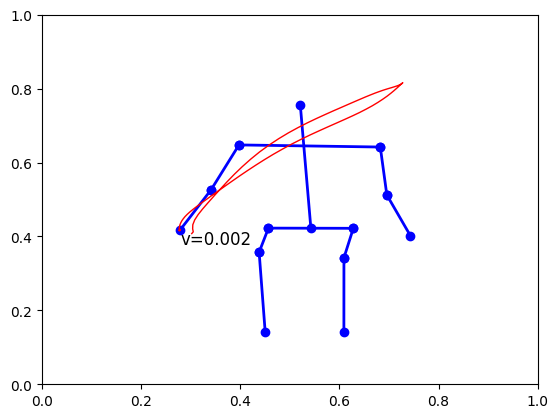

Node: NOSE
  Mean Position: (0.5127652542372882, 0.7507516949152543)
  Variance: (6.755565713875318e-05, 4.669785262855507e-06)
  Standard Deviation: (0.008219224850236984, 0.002160968593676342)
  Amplitude: (0.029700000000000004, 0.006999999999999895)
  Direction Vector: (0.010099999999999998, 0.0030000000000000027)

Node: LEFT_EYE
  Mean Position: (0.4883567796610168, 0.7647449152542374)
  Variance: (4.069770827348467e-05, 3.7828131284113677e-06)
  Standard Deviation: (0.006379475548466713, 0.0019449455335333603)
  Amplitude: (0.022800000000000042, 0.006500000000000061)
  Direction Vector: (0.008699999999999986, 0.0023999999999999577)

Node: RIGHT_EYE
  Mean Position: (0.5475677966101696, 0.7659398305084746)
  Variance: (5.517506463659863e-05, 3.5471423441539954e-06)
  Standard Deviation: (0.007427991965302509, 0.001883385872346396)
  Amplitude: (0.02849999999999997, 0.006599999999999939)
  Direction Vector: (0.007000000000000006, 0.00039999999999995595)

Node: LEFT_EAR
  Mean Positi

In [32]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np
import os

json_file = '/content/D1-flexion_golden_repetition.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)

for key, value in data.items():
    print(key, value)
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts

def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    for timestamp in data['golden_rep_poses']:
        positions = timestamp['pose']
        list_of_tuples_for_each_timestamp = [
            [positions[i], positions[i+1]] for i in range(0, 34, 2)
        ]
        list_of_positions.append(list_of_tuples_for_each_timestamp)
    return list_of_positions

def transform_list_of_positions(list_of_positions):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down

    When we will need to add a scale it's a good place to do so.

    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            # print(node)

    return list_of_positions

def center_skeleton(list_of_positions):
    """Centers the skeleton in the frame by shifting all coordinates."""
    for frame in list_of_positions:
        # Calculate the center of the skeleton
        x_coords = [node[0] for node in frame]
        y_coords = [node[1] for node in frame]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)

        # Shift all nodes to center the skeleton
        for node in frame:
            node[0] -= center_x - 0.5  # Centering on the x-axis (0.5 is the center)
            node[1] -= center_y - 0.5  # Centering on the y-axis (0.5 is the center)
    return list_of_positions

def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

def get_velocity(trace):
    x_vel = []
    y_vel = []
    for frame in trace:
        x_vel.append(frame[0])
        y_vel.append(frame[1])

    return np.gradient(np.array(x_vel)), np.gradient(np.array(y_vel))


HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')

# Add the connection from the MID_HIP to the NOSE
HUMAN_BLUEPRINT.append(('MID_HIP', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]

trace = get_trace('LEFT_WRIST', list_of_positions, body_parts)
x_vel, y_vel = get_velocity(trace)
# print(x_vel)
velocity = np.sqrt(x_vel**2 + y_vel**2)
# print(velocity)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
trace_line, = ax.plot([], [], 'r-', lw=1)
velocity_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=12, verticalalignment='top')



def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)


    if i < len(trace):
        trace_x = [pos[0] for pos in trace[:i+1]]
        trace_y = [pos[1] for pos in trace[:i+1]]
        trace_line.set_data(trace_x, trace_y)

    current_velocity = velocity[i]
    velocity_text.set_text(f'v={round(current_velocity, 3)}')
    velocity_text.set_position((trace_x[-1], trace_y[-1]))

    # print(velocity)
    return lines + [trace_line]

    # return lines

# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)
os.makedirs('Animations', exist_ok=True)
gif_path = os.path.join('Animations', os.path.basename(json_file).replace('.json', '_animation.gif'))
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()
# Calculate stability metrics for each node
stability_metrics = {}

for part, index in body_parts.items():
    x_positions = [frame[index][0] for frame in list_of_positions]
    y_positions = [frame[index][1] for frame in list_of_positions]

    # Mean position
    mean_x = np.mean(x_positions)
    mean_y = np.mean(y_positions)

    # Variance and standard deviation
    variance_x = np.var(x_positions)
    variance_y = np.var(y_positions)
    std_dev_x = np.std(x_positions)
    std_dev_y = np.std(y_positions)

    # Amplitude of motion
    amplitude_x = max(x_positions) - min(x_positions)
    amplitude_y = max(y_positions) - min(y_positions)

    # Direction vector (displacement)
    direction_vector = (x_positions[-1] - x_positions[0], y_positions[-1] - y_positions[0])

    stability_metrics[part] = {
        'mean_position': (mean_x, mean_y),
        'variance': (variance_x, variance_y),
        'std_dev': (std_dev_x, std_dev_y),
        'amplitude': (amplitude_x, amplitude_y),
        'direction_vector': direction_vector
    }

# Print the stability metrics
for part, metrics in stability_metrics.items():
    print(f"Node: {part}")
    print(f"  Mean Position: {metrics['mean_position']}")
    print(f"  Variance: {metrics['variance']}")
    print(f"  Standard Deviation: {metrics['std_dev']}")
    print(f"  Amplitude: {metrics['amplitude']}")
    print(f"  Direction Vector: {metrics['direction_vector']}")
    print()


config {'iou_threshold': 0.5, 'limb_activity_threshold': 0.25, 'node_axis_threshold': 0.15, 'number_points_displayed': 5}
used_nodes [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_EYE', 'index': 1}, {'name': 'RIGHT_EYE', 'index': 2}, {'name': 'LEFT_EAR', 'index': 3}, {'name': 'RIGHT_EAR', 'index': 4}, {'name': 'LEFT_SHOULDER', 'index': 5}, {'name': 'RIGHT_SHOULDER', 'index': 6}, {'name': 'LEFT_ELBOW', 'index': 7}, {'name': 'RIGHT_ELBOW', 'index': 8}, {'name': 'LEFT_WRIST', 'index': 9}, {'name': 'RIGHT_WRIST', 'index': 10}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}, {'name': 'LEFT_KNEE', 'index': 13}, {'name': 'RIGHT_KNEE', 'index': 14}, {'name': 'LEFT_FOOT', 'index': 15}, {'name': 'RIGHT_FOOT', 'index': 16}]
affine_transform_nodes [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}]
evaluation_nodes [{'name': 'NOSE', 'index': 0}]
golden_rep_poses [{'timestamp': 0, 'pose': [0.5386903882026672, 0.1582665145397186

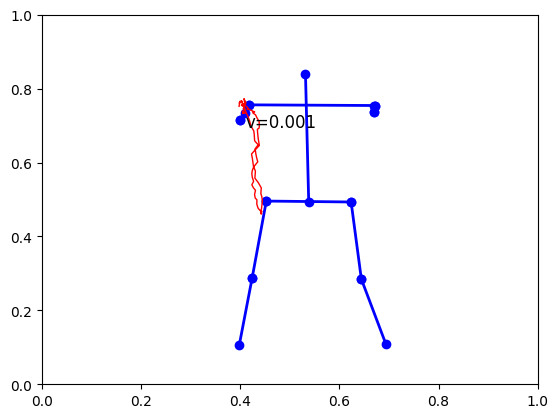

Node: NOSE
  Mean Position: (0.5497537906072578, 0.7081662858931386)
  Variance: (0.00015006493290054505, 0.01651688137127172)
  Standard Deviation: (0.01225009930166058, 0.12851801963643744)
  Amplitude: (0.04233580827713013, 0.3350173532962799)
  Direction Vector: (-0.006907343864440918, -0.0031780898571014404)

Node: LEFT_EYE
  Mean Position: (0.5204411355816588, 0.7226122015593003)
  Variance: (0.0001455778701315297, 0.016472596784466928)
  Standard Deviation: (0.01206556547085671, 0.1283456145899303)
  Amplitude: (0.038166165351867676, 0.3350023031234741)
  Direction Vector: (-0.004161179065704346, -0.0023455917835235596)

Node: RIGHT_EYE
  Mean Position: (0.5794378452155055, 0.7231948009254981)
  Variance: (0.00013981563671688617, 0.016579463804040264)
  Standard Deviation: (0.011824366228973381, 0.12876126670719057)
  Amplitude: (0.039286255836486816, 0.33660024404525757)
  Direction Vector: (-0.002162456512451172, -0.0011136829853057861)

Node: LEFT_EAR
  Mean Position: (0.4925

In [33]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np
import os

json_file = '/content/squat_golden_repetition.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)

for key, value in data.items():
    print(key, value)
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts

def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    for timestamp in data['golden_rep_poses']:
        positions = timestamp['pose']
        list_of_tuples_for_each_timestamp = [
            [positions[i], positions[i+1]] for i in range(0, 34, 2)
        ]
        list_of_positions.append(list_of_tuples_for_each_timestamp)
    return list_of_positions

def transform_list_of_positions(list_of_positions):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down

    When we will need to add a scale it's a good place to do so.

    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            # print(node)

    return list_of_positions

def center_skeleton(list_of_positions):
    """Centers the skeleton in the frame by shifting all coordinates."""
    for frame in list_of_positions:
        # Calculate the center of the skeleton
        x_coords = [node[0] for node in frame]
        y_coords = [node[1] for node in frame]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)

        # Shift all nodes to center the skeleton
        for node in frame:
            node[0] -= center_x - 0.5  # Centering on the x-axis (0.5 is the center)
            node[1] -= center_y - 0.5  # Centering on the y-axis (0.5 is the center)
    return list_of_positions

def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

def get_velocity(trace):
    x_vel = []
    y_vel = []
    for frame in trace:
        x_vel.append(frame[0])
        y_vel.append(frame[1])

    return np.gradient(np.array(x_vel)), np.gradient(np.array(y_vel))


HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')

# Add the connection from the MID_HIP to the NOSE
HUMAN_BLUEPRINT.append(('MID_HIP', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]

trace = get_trace('LEFT_WRIST', list_of_positions, body_parts)
x_vel, y_vel = get_velocity(trace)
# print(x_vel)
velocity = np.sqrt(x_vel**2 + y_vel**2)
# print(velocity)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
trace_line, = ax.plot([], [], 'r-', lw=1)
velocity_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=12, verticalalignment='top')



def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)


    if i < len(trace):
        trace_x = [pos[0] for pos in trace[:i+1]]
        trace_y = [pos[1] for pos in trace[:i+1]]
        trace_line.set_data(trace_x, trace_y)

    current_velocity = velocity[i]
    velocity_text.set_text(f'v={round(current_velocity, 3)}')
    velocity_text.set_position((trace_x[-1], trace_y[-1]))

    # print(velocity)
    return lines + [trace_line]

    # return lines

# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)
os.makedirs('Animations', exist_ok=True)
gif_path = os.path.join('Animations', os.path.basename(json_file).replace('.json', '_animation.gif'))
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()
# Calculate stability metrics for each node
stability_metrics = {}

for part, index in body_parts.items():
    x_positions = [frame[index][0] for frame in list_of_positions]
    y_positions = [frame[index][1] for frame in list_of_positions]

    # Mean position
    mean_x = np.mean(x_positions)
    mean_y = np.mean(y_positions)

    # Variance and standard deviation
    variance_x = np.var(x_positions)
    variance_y = np.var(y_positions)
    std_dev_x = np.std(x_positions)
    std_dev_y = np.std(y_positions)

    # Amplitude of motion
    amplitude_x = max(x_positions) - min(x_positions)
    amplitude_y = max(y_positions) - min(y_positions)

    # Direction vector (displacement)
    direction_vector = (x_positions[-1] - x_positions[0], y_positions[-1] - y_positions[0])

    stability_metrics[part] = {
        'mean_position': (mean_x, mean_y),
        'variance': (variance_x, variance_y),
        'std_dev': (std_dev_x, std_dev_y),
        'amplitude': (amplitude_x, amplitude_y),
        'direction_vector': direction_vector
    }

# Print the stability metrics
for part, metrics in stability_metrics.items():
    print(f"Node: {part}")
    print(f"  Mean Position: {metrics['mean_position']}")
    print(f"  Variance: {metrics['variance']}")
    print(f"  Standard Deviation: {metrics['std_dev']}")
    print(f"  Amplitude: {metrics['amplitude']}")
    print(f"  Direction Vector: {metrics['direction_vector']}")
    print()
